 ## Perform data analysis with unsupervised methods k-means and agglomerative clustering for the following dataset:
 
- from sklearn.datasets import load_wine
- wine = load_wine()
- df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
- df_wine['target'] = wine.target
 
## Rubric
 
- EDA – 10pts
- Visuals – dendrograms, elbow plots, scatter plots – 15 pts
- Data Prep – PCA, feature selection – 10 pts
- Model hyperparameter setup – 15 pts
- Results and analysis – compare methods – 20 pts

In [52]:
# cell for importing packages and modules

# usual imports
import pandas as pd               # dataframe stuff
import seaborn as sns             # data visualization
import matplotlib.pyplot as plt   # data visulaization

# for math
import numpy as np
import statistics

# source data
from sklearn.datasets import load_wine               # working dataset

# data processing
from sklearn.model_selection import train_test_split # split to train and test set. Can use to stratify (ensure spread of classes is equally represented in split) - might not need this
from sklearn.preprocessing import StandardScaler     # Standard scaler, mean of 0 and std deviation of 1. Helps understand data on similar scale
from sklearn.preprocessing import LabelEncoder       # change objects to integers
from sklearn.decomposition import PCA                # Principal Component Analysis (PCA) for dimensionality reduction technique

# models
from sklearn.cluster import DBSCAN                   # Density based clustering algorithm used to identify clusters in data based on distance
from sklearn.cluster import KMeans                   # Clustering approach for partitioning data into K distinct, non-overlapping clusters
from sklearn.cluster import AgglomerativeClustering  # Bottom-up clustering. Starts each datapoint as its own cluster (For Hiearchical Clustering)
from scipy.cluster.hierarchy import dendrogram, linkage  # Dendogram visuals and post-cluster merge distance matrix updating. (For Hiearchical Clustering)

# model automation
from sklearn.pipeline import Pipeline                # Chain multiple data preprocessing and modeling steps together into a single object. This simplifies the workflow and helps to prevent data leakage
from sklearn.model_selection import GridSearchCV     # Used for hyperparameter tuning in machine learning models.(1)It exhaustively searches through a specified grid of hyperparameter (2) values to find the best combination that maximizes model performance.

# metrics
from sklearn.metrics import silhouette_score, silhouette_samples, make_scorer

# ignore warnings - theres way too many of them coming up in GridSearchCV saying there is no y_true passed in and memory leak stuff.
import warnings
warnings.filterwarnings('ignore') #ignore warnings

## Part 1: EDA - 10pts

In [2]:
# data init

wine = load_wine()
data = pd.DataFrame(data=wine.data, columns=wine.feature_names)
data["target"] = wine.target
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [4]:
data.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

<Axes: >

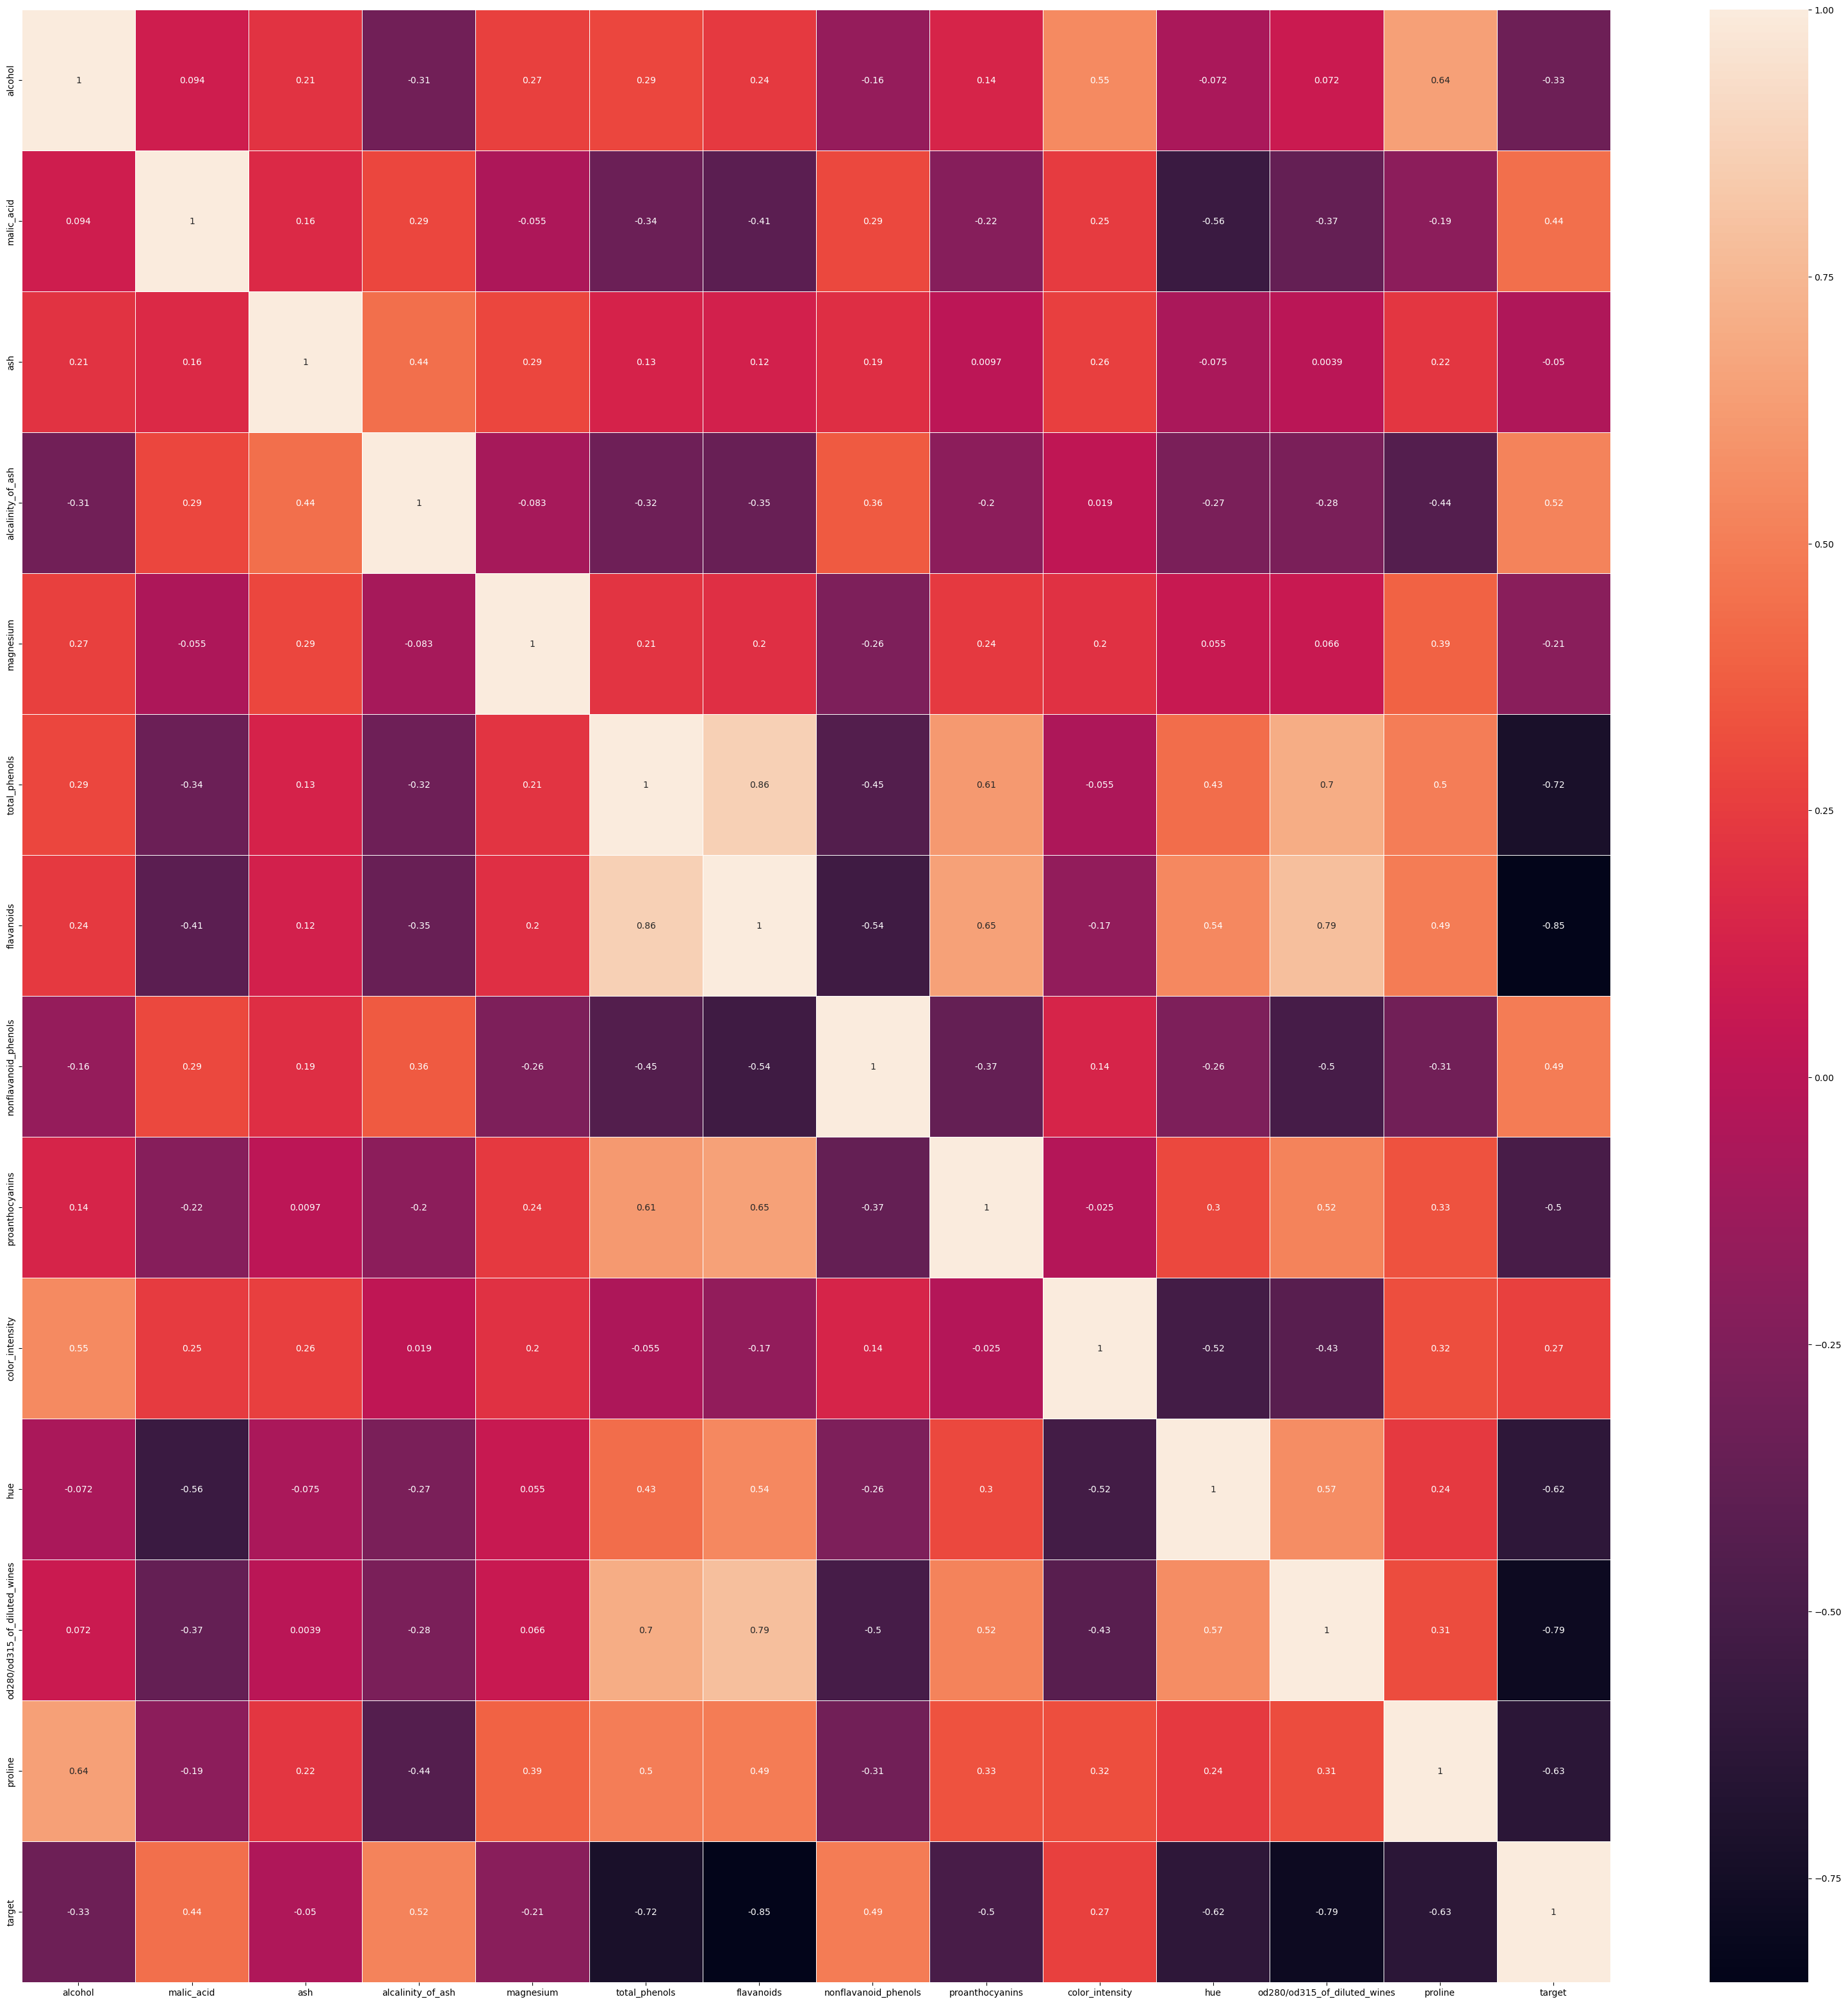

In [5]:
corr_array = data.corr()
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(corr_array, annot=True, linewidths=0.5, ax=ax)

- Seems like there are a couple highly correlated features

======= alcohol =====
Kurtosis: -0.8524995684849164
Skew: -0.051482331077134784


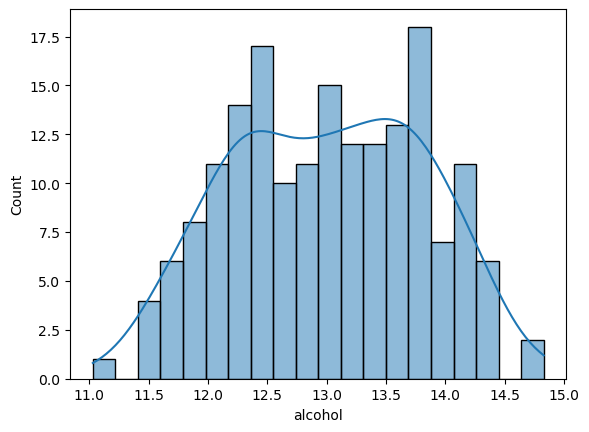

======= malic_acid =====
Kurtosis: 0.2992066798717512
Skew: 1.0396511925814442


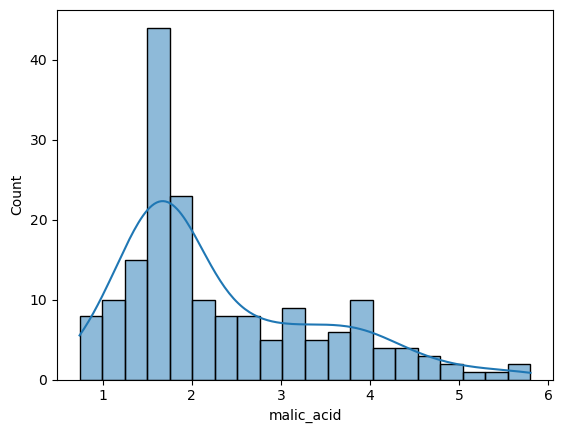

======= ash =====
Kurtosis: 1.1439781688330677
Skew: -0.17669931645735712


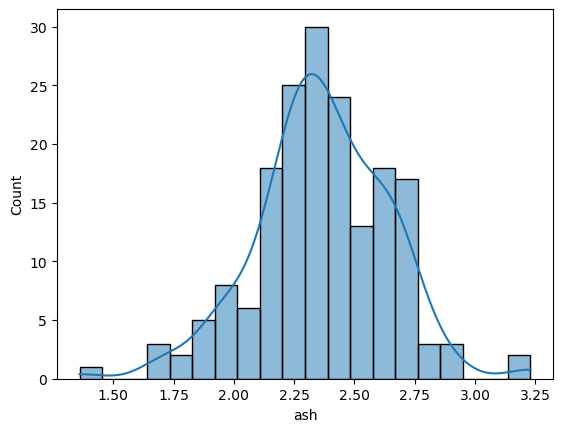

======= alcalinity_of_ash =====
Kurtosis: 0.4879415404679124
Skew: 0.21304688642645586


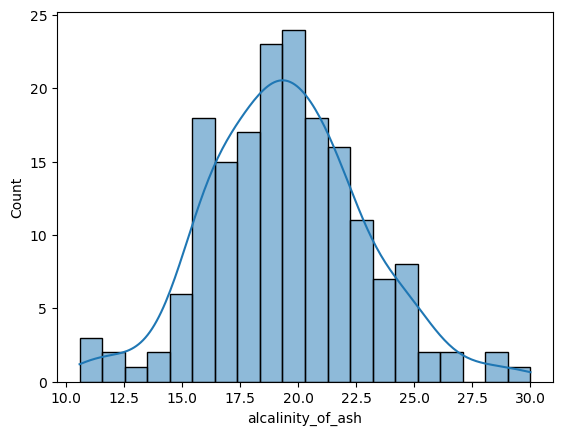

======= magnesium =====
Kurtosis: 2.1049913235905557
Skew: 1.098191054755161


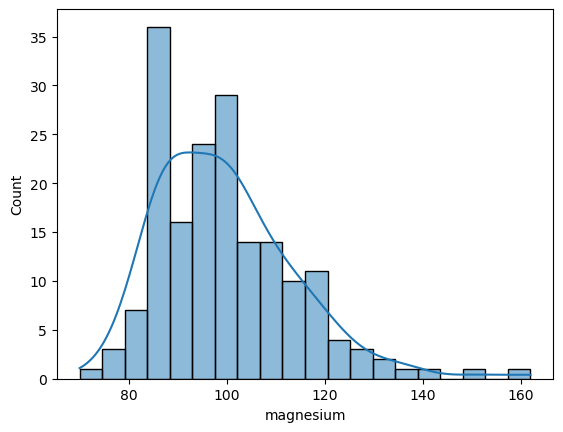

======= total_phenols =====
Kurtosis: -0.8356265233980293
Skew: 0.08663858640245253


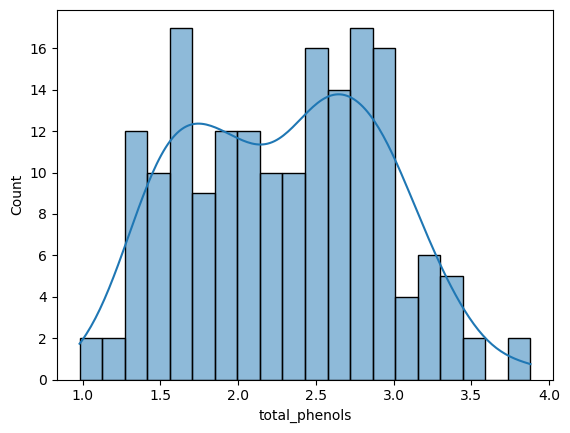

======= flavanoids =====
Kurtosis: -0.8803815472453591
Skew: 0.02534355338149103


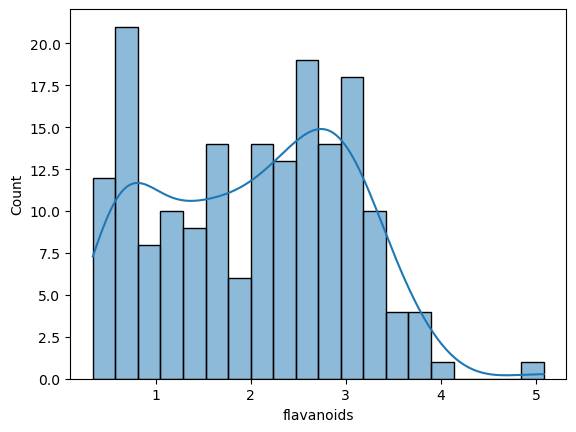

======= nonflavanoid_phenols =====
Kurtosis: -0.6371910641424079
Skew: 0.4501513355621236


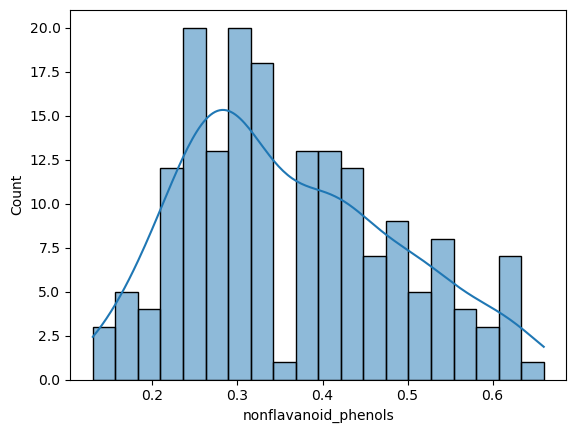

======= proanthocyanins =====
Kurtosis: 0.5546485226011098
Skew: 0.5171371722998975


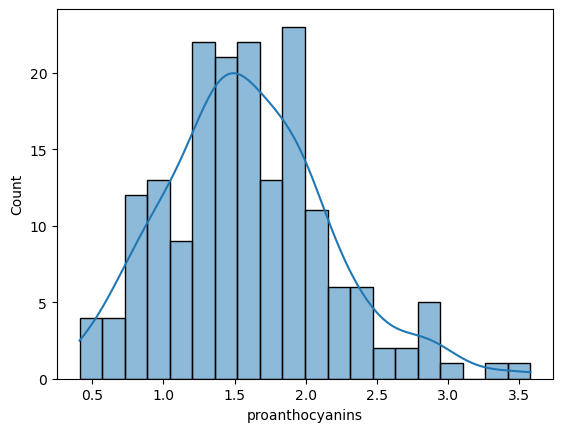

======= color_intensity =====
Kurtosis: 0.38152227277478135
Skew: 0.8685847909572548


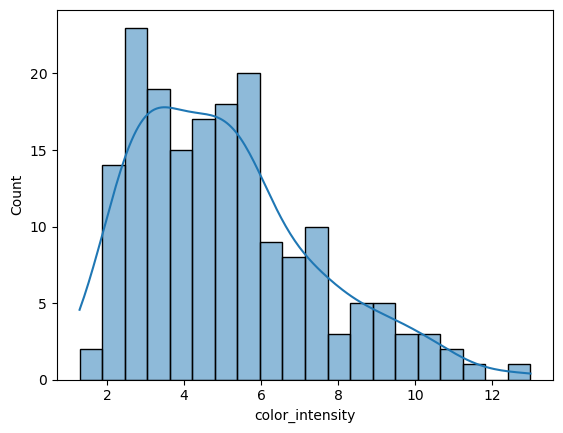

======= hue =====
Kurtosis: -0.3440957413614769
Skew: 0.021091272199709302


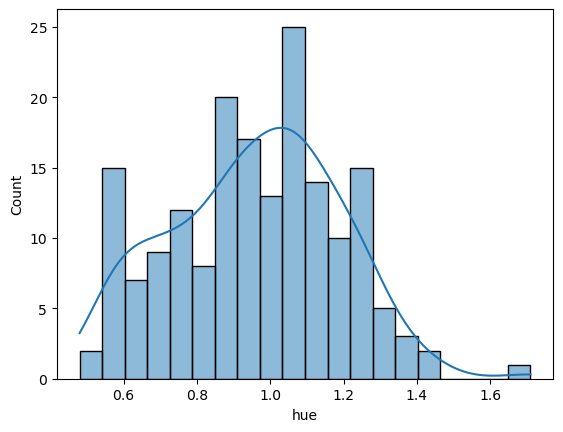

======= od280/od315_of_diluted_wines =====
Kurtosis: -1.0864345274098695
Skew: -0.30728549895848106


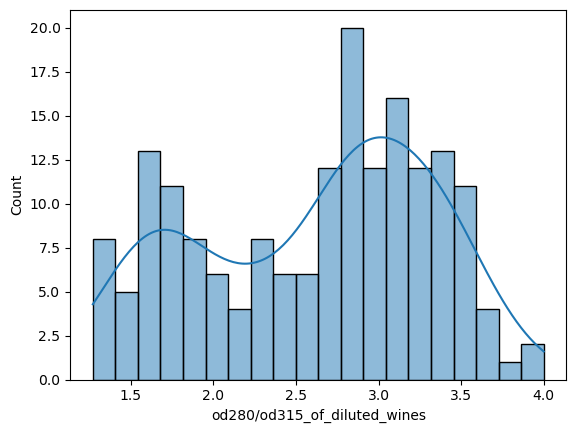

======= proline =====
Kurtosis: -0.24840310614613248
Skew: 0.7678217813897322


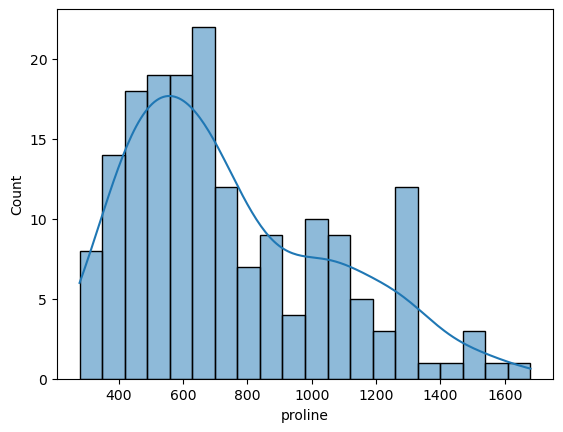

======= target =====
Kurtosis: -1.3227866741571241
Skew: 0.10743112358094281


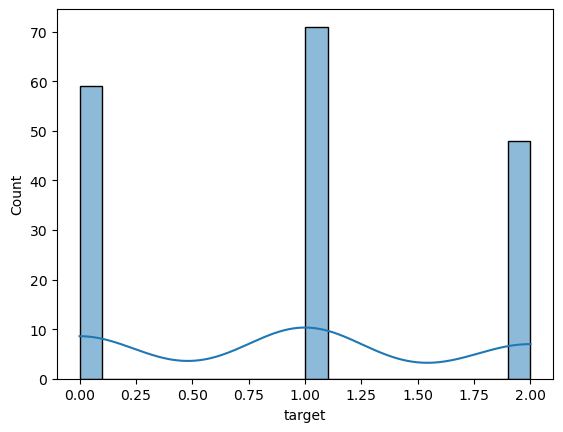

Average Kurtosis:  -0.08822358887186697
Average Skew:  0.33283011450312083


In [6]:
# Review of data spread per feature

kurtosis_list = []
skew_list = []
for feature in data.columns:
    print(f"======= {feature} =====") 
    print("Kurtosis:", data[feature].kurtosis())
    print("Skew:", data[feature].skew())
    
    plt.figure(data.columns.get_loc(feature)+1)
    sns.histplot(data[feature], kde=True, bins=20)
    plt.show()

    kurtosis_list.append(data[feature].kurtosis())
    skew_list.append(data[feature].skew())

print("Average Kurtosis: ",statistics.mean(kurtosis_list))
print("Average Skew: ",statistics.mean(skew_list))

- Seems like this data is really close to being normally distributed on average.

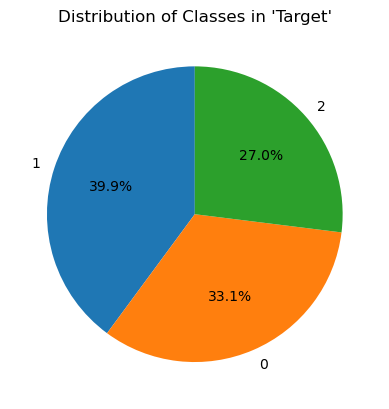

In [7]:
# Show the percentage spread of classess in data["target"]

class_counts = data["target"].value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Distribution of Classes in 'Target'")
plt.show()

- This distribution of classes in "target" is pretty good. Not perfectly even, but close to it

<Figure size 640x480 with 0 Axes>

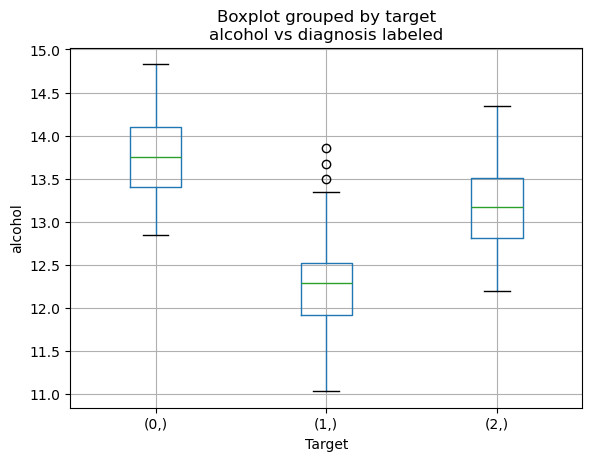

<Figure size 640x480 with 0 Axes>

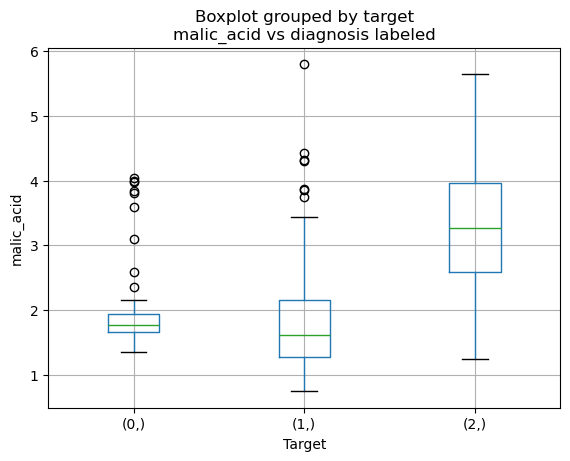

<Figure size 640x480 with 0 Axes>

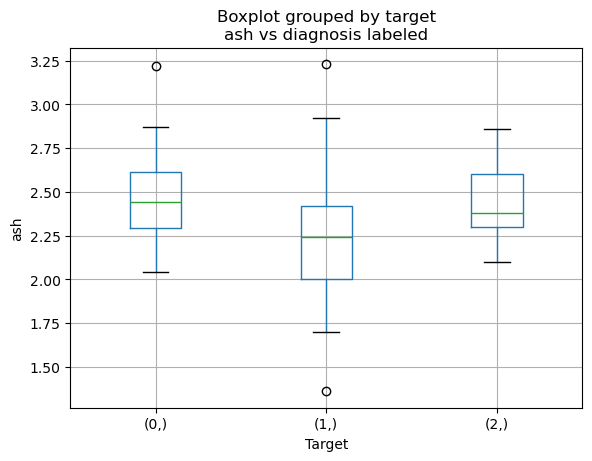

<Figure size 640x480 with 0 Axes>

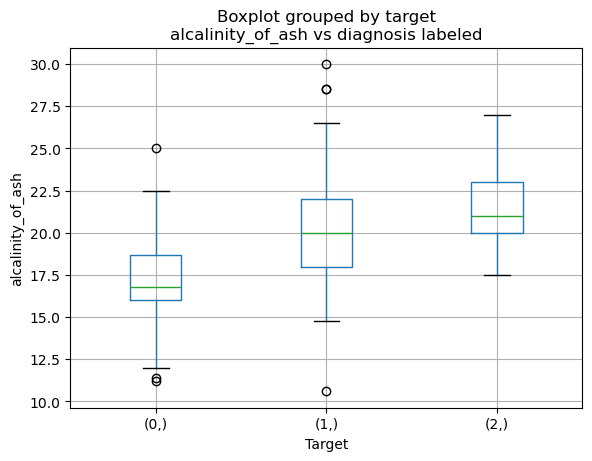

<Figure size 640x480 with 0 Axes>

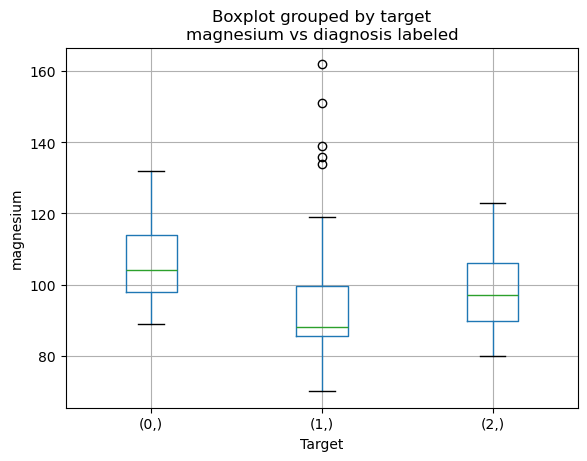

<Figure size 640x480 with 0 Axes>

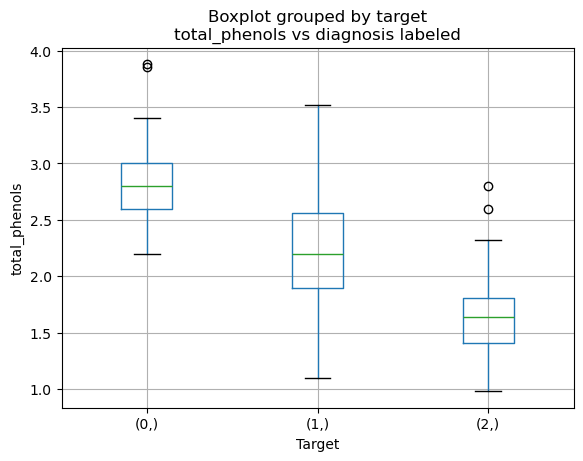

<Figure size 640x480 with 0 Axes>

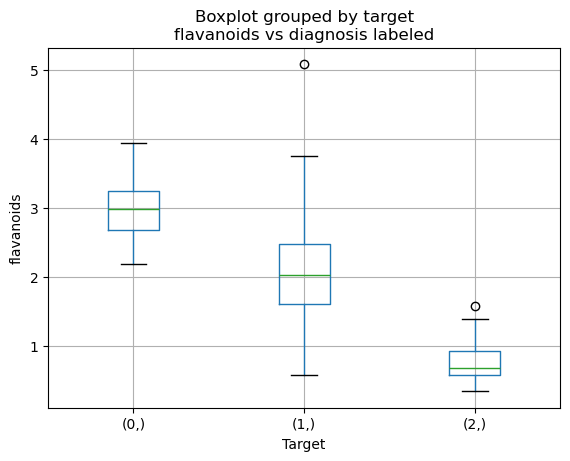

<Figure size 640x480 with 0 Axes>

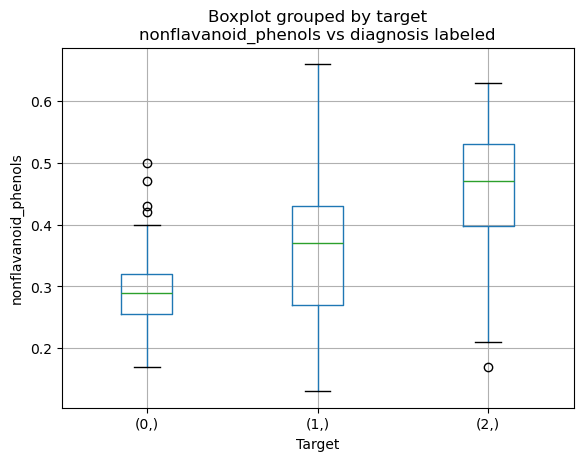

<Figure size 640x480 with 0 Axes>

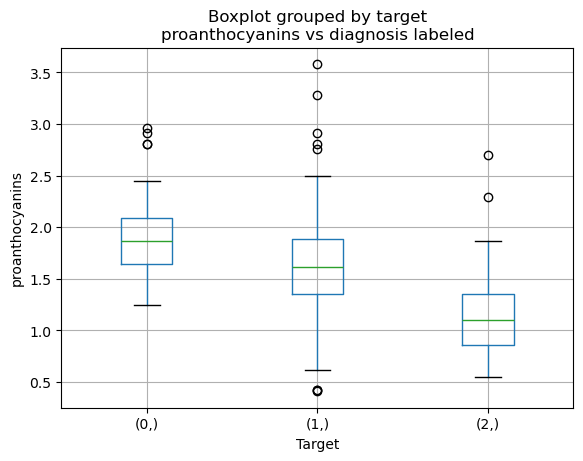

<Figure size 640x480 with 0 Axes>

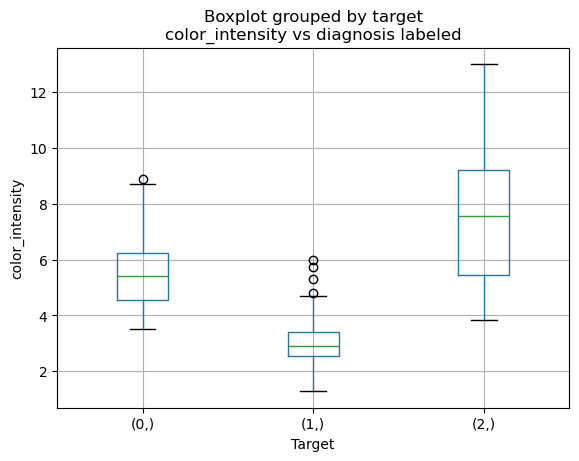

<Figure size 640x480 with 0 Axes>

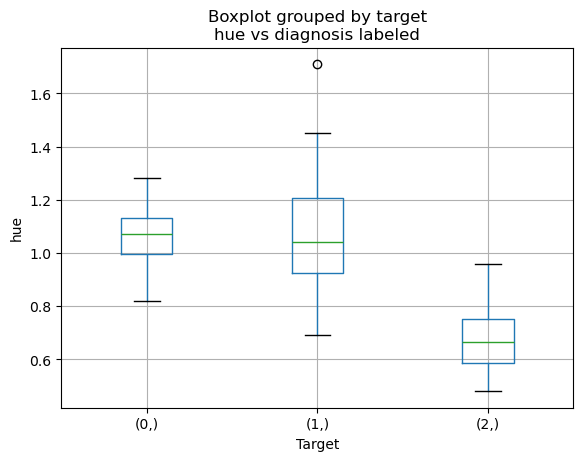

<Figure size 640x480 with 0 Axes>

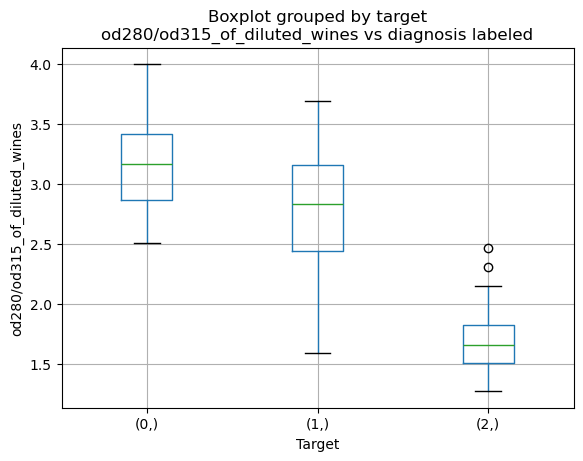

<Figure size 640x480 with 0 Axes>

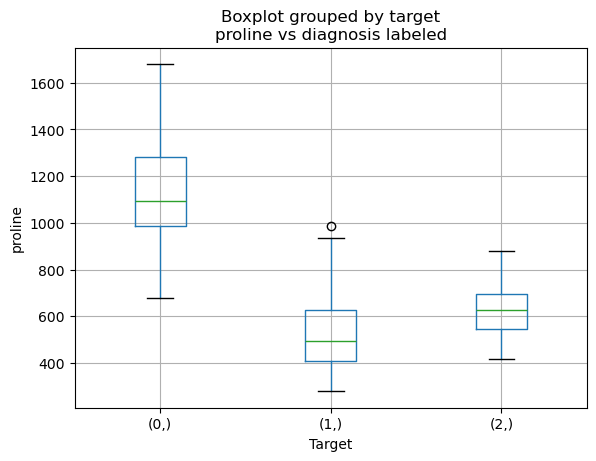

<Figure size 640x480 with 0 Axes>

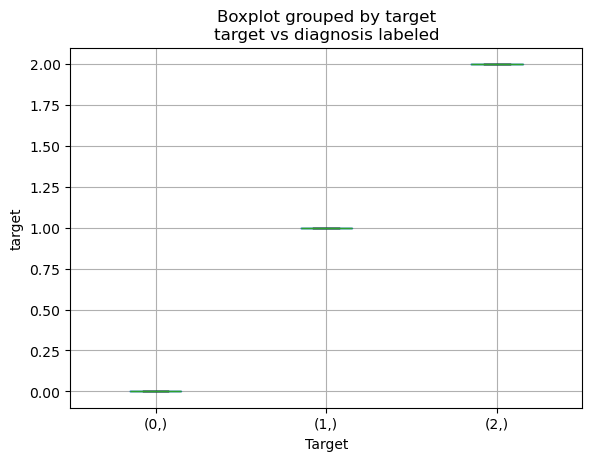

In [8]:
# Boxplot to review outliers per class

for feature in data.columns:
    plt.figure(data.columns.get_loc(feature)+1)
    data.boxplot(column=feature, by=["target"])
    plt.xlabel("Target")
    plt.ylabel(feature)    
    plt.title(f"{feature} vs diagnosis labeled")
    plt.show()

<Axes: >

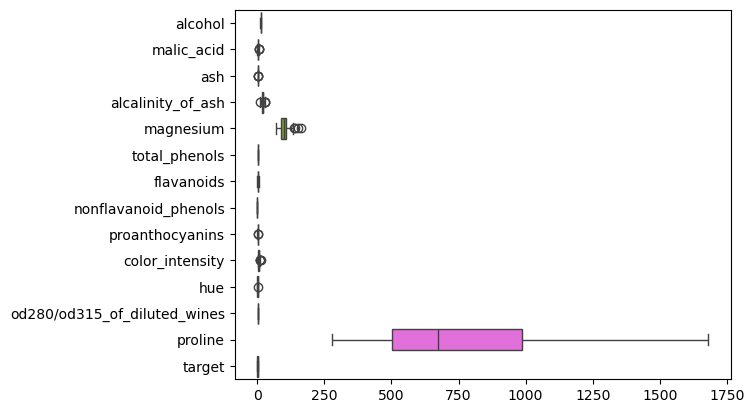

In [9]:
# boxplot to review outliers for each feature

sns.boxplot(data=data, orient='h')

- There are a few outliers here and there, but not enough to call any one feature worth removing. I won't be removing any outliers in the initial model either to get a baseline.
- Going to try using StandardScaler to see what it looks like on the same scale. The above is hard to read.

<Axes: >

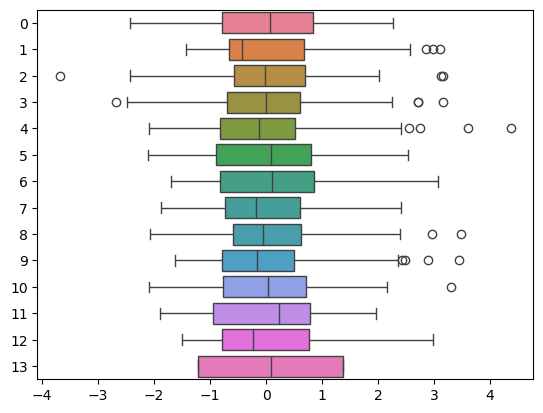

In [10]:
# boxplot to review outliers for each feature with StandardScaler()

scaler = StandardScaler()

data_std_scale = pd.DataFrame(scaler.fit_transform(data))
sns.boxplot(data=data_std_scale, orient='h')

- again, not too many outliers, thats good

======= alcohol =====
Kurtosis: -0.8163046439075825
Skew: -0.1518291731466355


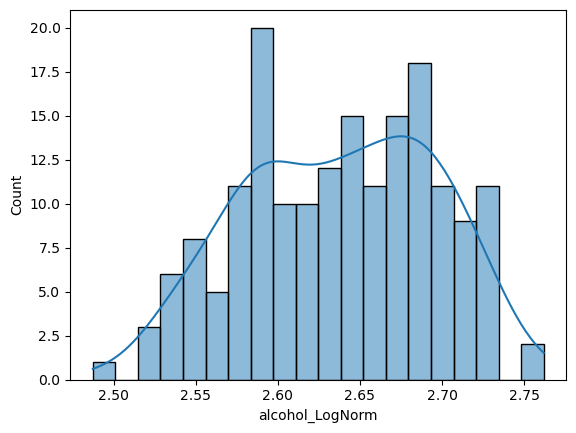

======= malic_acid =====
Kurtosis: -0.6040201703856409
Skew: 0.5292217316370484


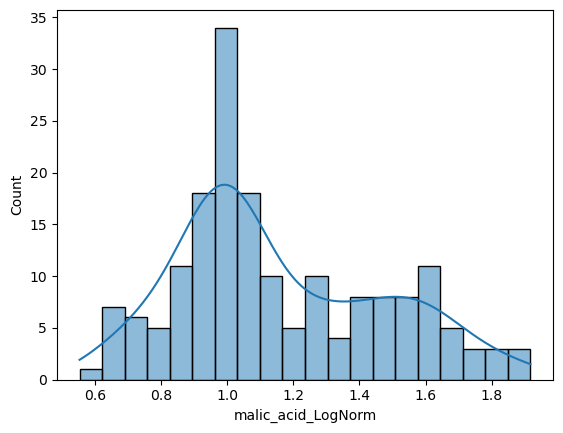

======= ash =====
Kurtosis: 1.7258672733333493
Skew: -0.5741518640589696


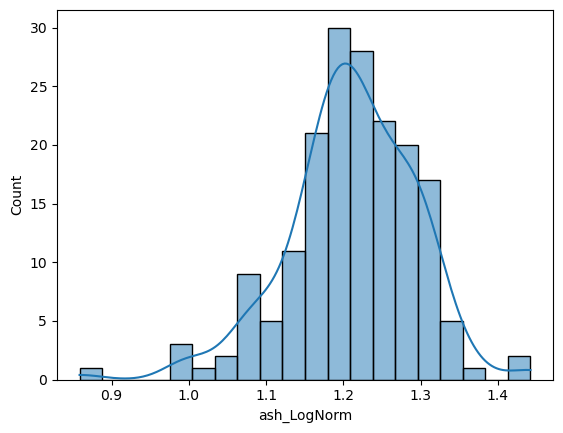

======= alcalinity_of_ash =====
Kurtosis: 0.8581804724272812
Skew: -0.4103606011647306


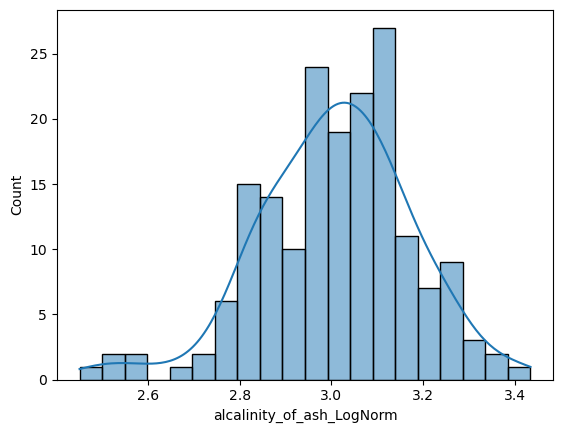

======= magnesium =====
Kurtosis: 0.6169525727474423
Skew: 0.6057231291674979


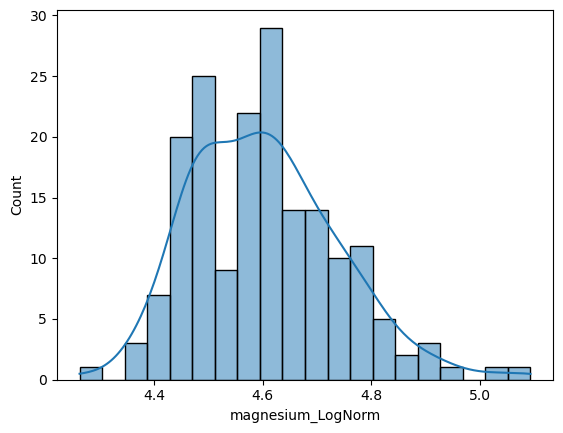

======= total_phenols =====
Kurtosis: -0.8539037796669433
Skew: -0.2326422019493981


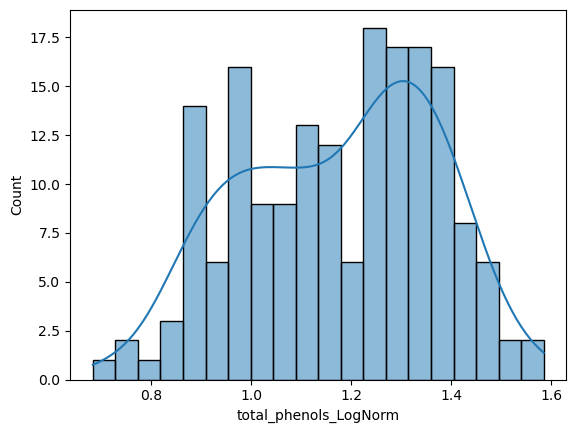

======= flavanoids =====
Kurtosis: -1.0164396082231404
Skew: -0.44559968834920793


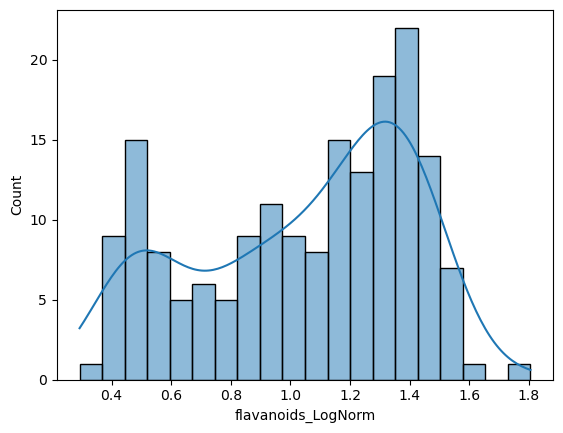

======= nonflavanoid_phenols =====
Kurtosis: -0.7459049891097798
Skew: 0.29369660706236567


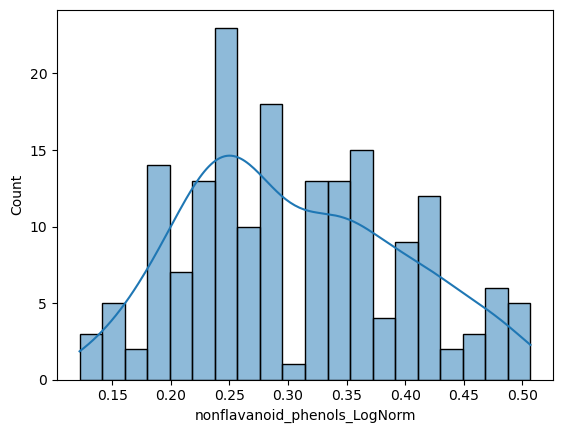

======= proanthocyanins =====
Kurtosis: 0.08169912136939939
Skew: -0.17166932661596043


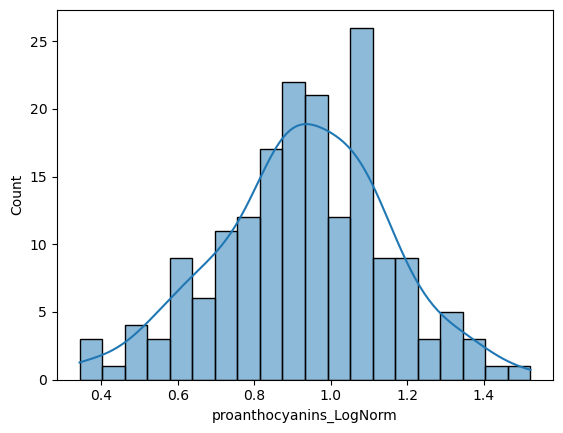

======= color_intensity =====
Kurtosis: -0.6450946805852489
Skew: 0.09722224038648299


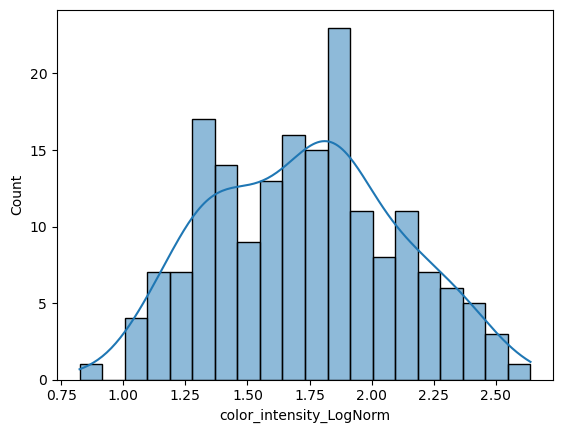

======= hue =====
Kurtosis: -0.5415372874206081
Skew: -0.24126894094523144


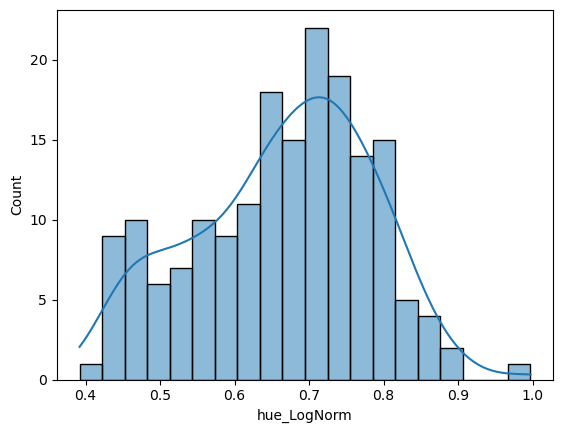

======= od280/od315_of_diluted_wines =====
Kurtosis: -0.9272487907572304
Skew: -0.5522494011787304


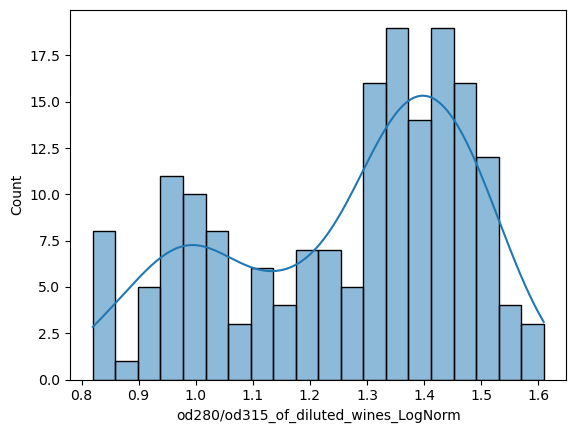

======= proline =====
Kurtosis: -0.834472073863572
Skew: 0.0879295192831045


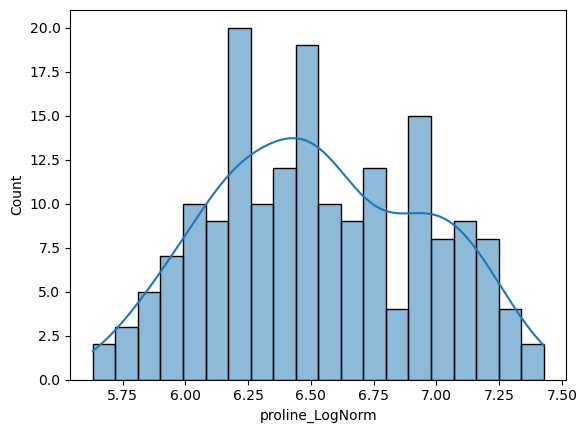

======= target =====
Kurtosis: -1.429611736572279
Skew: -0.27424807800163903


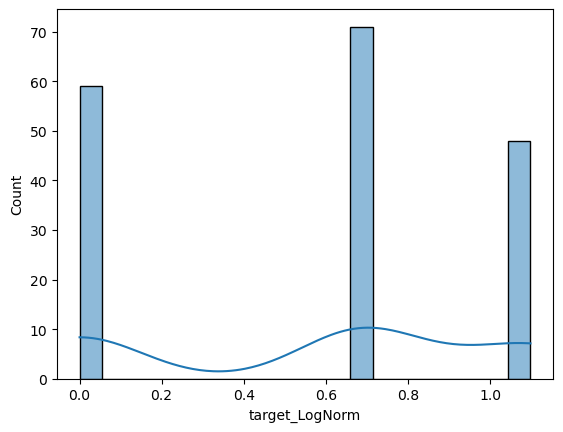

Average Kurtosis:  -0.36655988004389667
Average Skew:  -0.10287328913385739


In [11]:
# Normalizing data to see spread

kurtosis_list = []
skew_list = []
data_LogNorm = pd.DataFrame()
for feature in data.columns:
    data_LogNorm[f"{feature}_LogNorm"] = np.log1p(data[feature])
    kurt = data_LogNorm[f"{feature}_LogNorm"].kurtosis()
    skew = data_LogNorm[f"{feature}_LogNorm"].skew()
    
    print(f"======= {feature} =====") 
    print("Kurtosis:", kurt)
    print("Skew:", skew)
    
    plt.figure(data.columns.get_loc(feature)+1)
    sns.histplot(data_LogNorm[f"{feature}_LogNorm"], kde=True, bins=20)
    plt.show()

    kurtosis_list.append(kurt)
    skew_list.append(skew)

print("Average Kurtosis: ", statistics.mean(kurtosis_list))
print("Average Skew: ",statistics.mean(skew_list))

- Seems like the data is still very evenly spread. Will not be using this for now, but interesting to know

## Part 2: Visuals - 15 pts
- Dendograms
- Elbow Plots
- Scatter plots

In [12]:
X = data.drop("target", axis=1)
y = data["target"]

In [13]:
# scaling X data

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

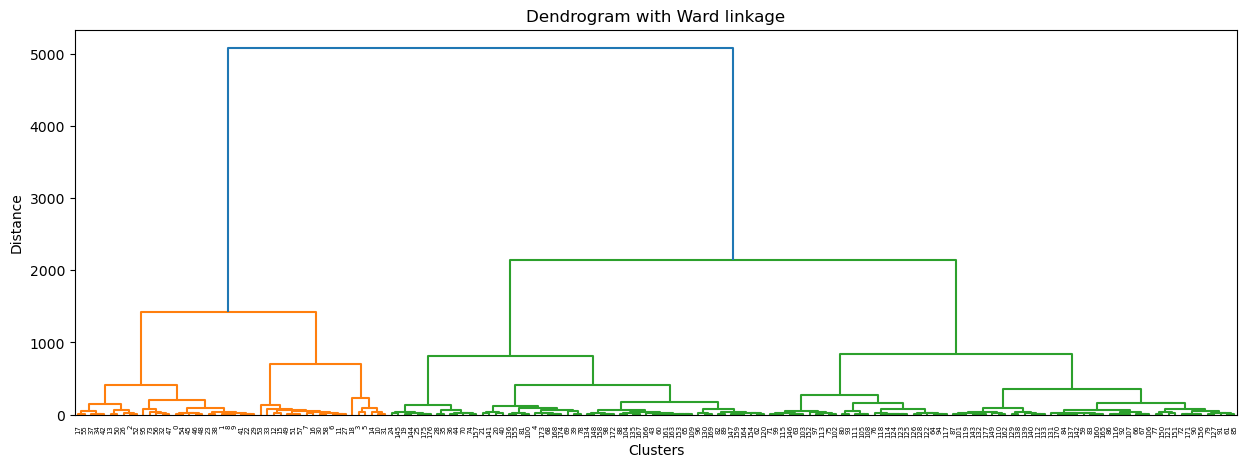

In [14]:
# Generating a dendrogram
dend_linkage = "ward"
data_linked = linkage(X, dend_linkage)

plt.figure(figsize=(15,5))
dendrogram(data_linked)
plt.title(f"Dendrogram with {dend_linkage.title()} linkage")
plt.xlabel("Clusters")
plt.ylabel("Distance")
plt.show()

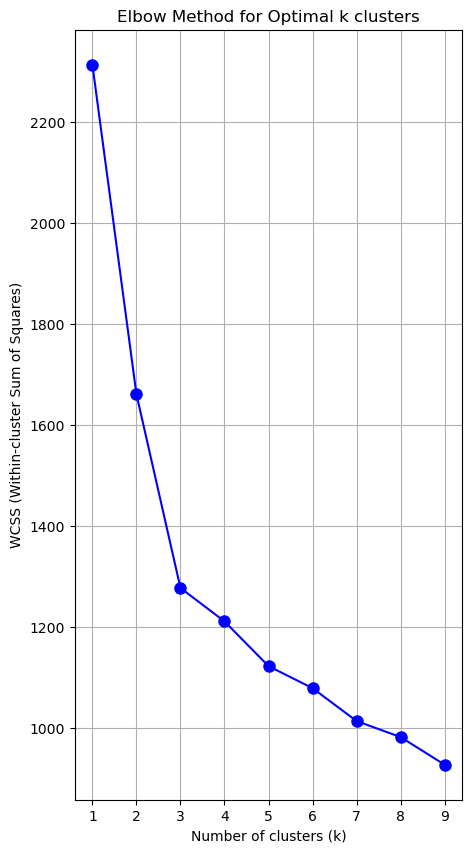

In [15]:
# Generating a Elbow Plot

wcss = []
K = range(1,10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# plot the elbow curve
plt.figure(figsize=(5,10))
plt.plot(K, wcss, "bo-", markersize=8)
plt.title("Elbow Method for Optimal k clusters")
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.grid(True)
plt.show()

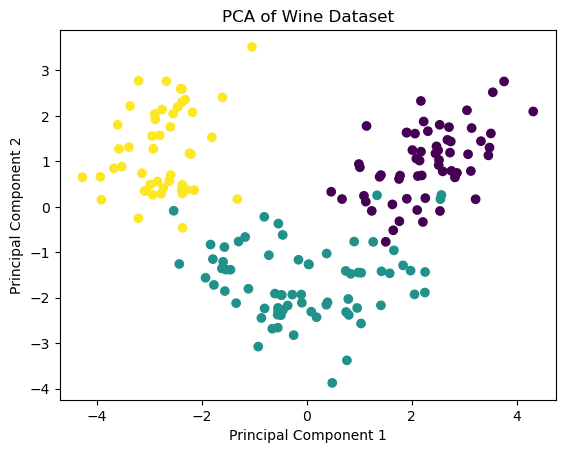

In [16]:
# Generating a Scatter plot

X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Wine Dataset')
plt.show()

In [17]:
X_pca_3d = PCA(n_components=3).fit_transform(X_scaled)

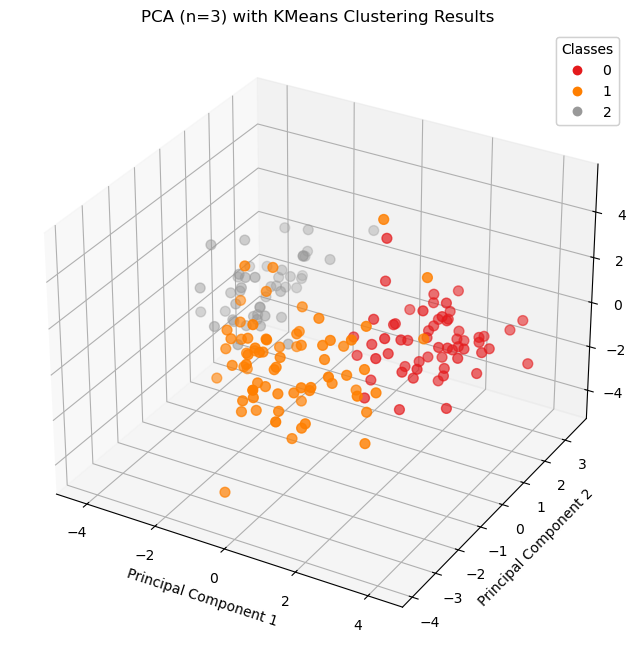

In [18]:
# 3d scatter plot of principle components

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the PCA-transformed data colored by KMeans cluster labels
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='Set1', s=50)

# Customize the plot
ax.set_title('PCA (n=3) with KMeans Clustering Results')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.grid(True)

# Add a legend
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)


# Show the 3D plot
plt.show()

## Part 3: Data Prep – 10 pts
- PCA
- Feature Selection


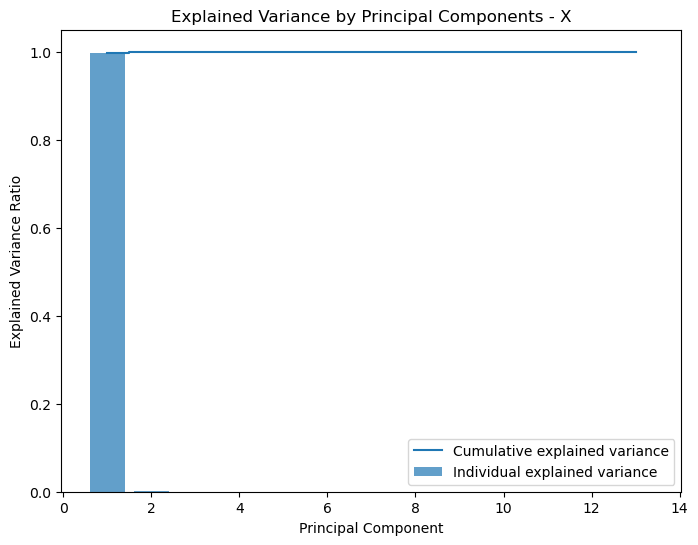

In [19]:
pca = PCA()
pca.fit(X)

# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center',
        label='Individual explained variance')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid',
         label='Cumulative explained variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components - X')
plt.show()

In [20]:
# Identify highly correlated features and remove them (corr score > 0.8)

mask = np.tril(np.ones(corr_array.shape), k=-1).astype(bool) #Creates a mask for the lower triangular part of the correlation_array, excluding diagonal
filtered_values = corr_array.where(mask & (corr_array > 0.8)).stack() #apply the mask and filter values greater than 0.8
print(filtered_values)

features_to_remove = list(set(filtered_values.index.get_level_values(0)))
print(features_to_remove)

flavanoids  total_phenols    0.864564
dtype: float64
['flavanoids']


In [21]:
data_trimmed = data.drop(features_to_remove, axis=1)

<Axes: >

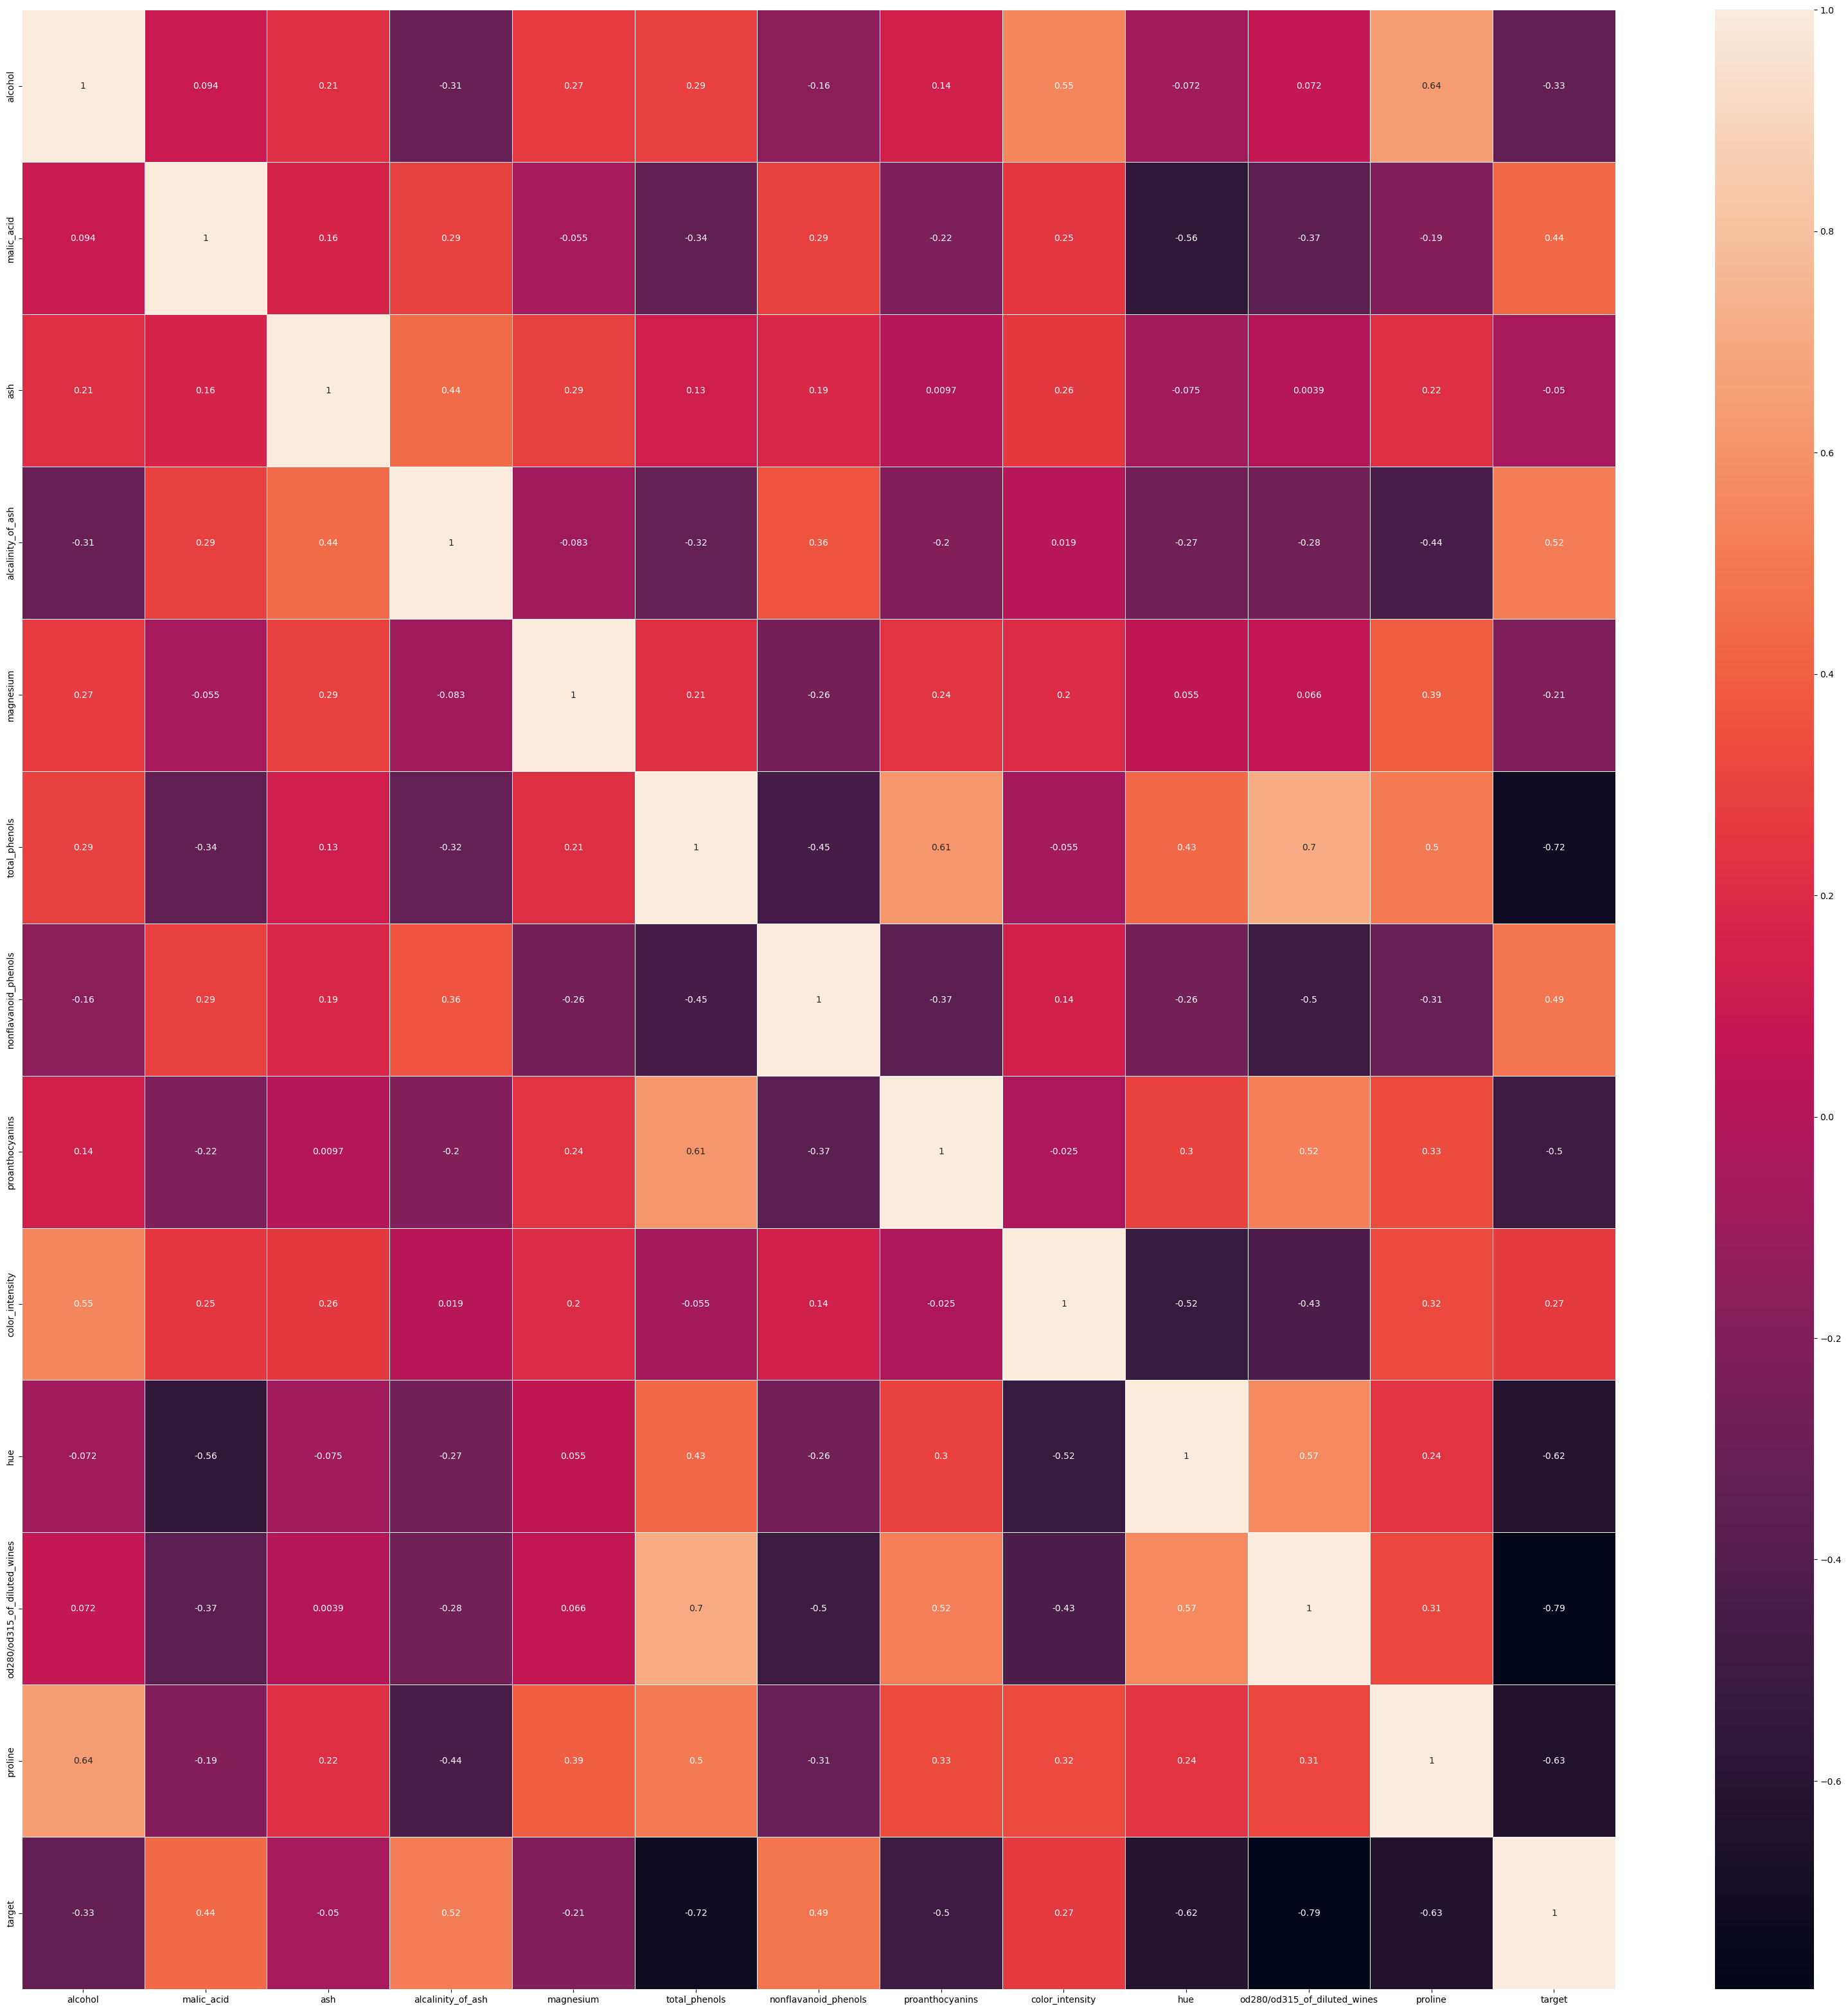

In [22]:
# New correlation heatmap for the trimmed data
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(data_trimmed.corr(), annot=True, linewidths=0.5, ax=ax)

## Part 4: Model hyperparameter setup – 15 pts

In [23]:
models = ["dbscan", "agg_clustering", "kmeans"]

In [24]:
# making a dict of model classes: model_classes
model_classes = {"dbscan": DBSCAN(),
                 "agg_clustering": AgglomerativeClustering(),
                 "kmeans": KMeans()
                }

In [25]:
# making a dict of dicts that holds parameter grids for each model: model_param_grids

model_param_grids = {
    "dbscan": {
        "dbscan__eps": [0.3, 0.5, 0.7, 1.0, 1.5],
        "dbscan__min_samples":[2, 3, 5, 10]  
    },
    "agg_clustering": {
        "agg_clustering__n_clusters": [2, 3, 4, 5],
        "agg_clustering__linkage": ["single", "average", "complete", "ward"],
        "agg_clustering__metric": ["euclidean", "manhattan"]
    },
    "kmeans": {
        "kmeans__n_clusters": [2, 3, 4, 5],
        "kmeans__init": ["k-means++", "random"],
    }
}

In [26]:
# making loop that fills a dict with model pipelines - all StandardScaler: model_pipelines

model_pipelines = {}

for model in models:
    model_pipelines[model] = Pipeline(
        [
            (f"{model}_scaler", StandardScaler()),
            (model, model_classes[model])   # this line assignes each model name to their respective model
        ],
        verbose=True  # Time elapsed while fitting each step will be printed as it is completed
)

for key, value in model_pipelines.items():
    print(f"{key} \n {value} \n")

dbscan 
 Pipeline(steps=[('dbscan_scaler', StandardScaler()), ('dbscan', DBSCAN())],
         verbose=True) 

agg_clustering 
 Pipeline(steps=[('agg_clustering_scaler', StandardScaler()),
                ('agg_clustering', AgglomerativeClustering())],
         verbose=True) 

kmeans 
 Pipeline(steps=[('kmeans_scaler', StandardScaler()), ('kmeans', KMeans())],
         verbose=True) 



In [27]:
# making a silhouette_scorer function that will be called later when scoring using GridSearchCV (think there might be some problem with this but can't tell if there is or not)

def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)    
    if len(set(labels)) > 1 and -1 not in labels:
        return silhouette_score(X, labels)
    else:
        return -1

In [28]:
# process gridsearch and find best model params using model_pipelines and model_param_grids: grid_search_models
import time #for timing how long this takes

def process_gridsearch(X, model_pipelines, model_param_grids, models):
    start_time = time.time()
    
    grid_search_models = {}
    
    for model in models:
        print(f"============= START PROCESSING MODEL: {model} =============")
    
        # Assign GridSearchCV object with parameters
        grid_search_models[model] = GridSearchCV(estimator  = model_pipelines[model], 
                                                 param_grid = model_param_grids[model], 
                                                 scoring    = make_scorer(silhouette_scorer), 
                                                 verbose    = 1
                                                )
        # fit model with data X
        grid_search_models[model].fit(X)                 
        print(f"============= END PROCESSING MODEL: {model} =============\n\n\n")
    
    for model in models:
        print(f"========== Model: {model} ==========")
        print(f"{model.upper()} Best parameters: ", grid_search_models[model].best_params_)
        print(f"{model.upper()} Best sil score: ", grid_search_models[model].best_score_)
    
    
    end_time = time.time()
    
    print("\nelapsed time (seconds): ", end_time-start_time)

    return grid_search_models

grid_search_models = process_gridsearch(X_pca, model_pipelines, model_param_grids, models)

============= START PROCESSING MODEL: dbscan =============
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Pipeline] ..... (step 1 of 2) Processing dbscan_scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing dbscan, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing dbscan_scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing dbscan, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing dbscan_scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing dbscan, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing dbscan_scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing dbscan, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing dbscan_scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing dbscan, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing dbscan_scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing dbscan, total=   0.0s
[Pipeline] ..... (step 1 of

## Part 5: Results and analysis – compare methods – 20 pts

In [29]:
# generate models from best parameters

def gen_mdls_from_best_params(X, grid_search_models, models):
    # creating a bunch of dicts to store data into with a loop (cuts down on amount of cells being used)    
    best_mdls={}
    sil_mdls = {}
    labels_mdls = {}
    
    for model in models:
        # model storing and processing
        best_mdls[model] = grid_search_models[model].best_estimator_    # grab model's best estimator
    
        # use the model's best estimator to predict labels with data - All models were fitted in the earlier step with gridsearch. now I am just pulling labels
        if model in ["dbscan", "agg_clustering"]:
            labels_mdls[model] = best_mdls[model].named_steps[model].labels_
        if model == "kmeans":
            labels_mdls[model] = best_mdls[model].predict(X)    
        
        try:
            sil_mdls[model] = silhouette_samples(X, labels_mdls[model])              # generate a silhouette score for each model
            print(f"Model: {model.upper()}    Silhouette Score: {sil_mdls[model].mean()}")  # print out the model name and the related silhouette score
        except Exception as e:
            print(f"Error with {model}")
            print(e)
            print(f"These are the labels for the model: {labels_mdls[model]}")
            print(f"Best estimator per model: {grid_search_models[model].best_estimator_}")
    return best_mdls, sil_mdls, labels_mdls

# run the function here (turned it into a function so I can pass in differnt X if desired
best_mdls, sil_mdls, labels_mdls = gen_mdls_from_best_params(X_pca, grid_search_models, models)

Model: DBSCAN    Silhouette Score: 0.08162055647205131
Model: AGG_CLUSTERING    Silhouette Score: 0.1855861563600241
Model: KMEANS    Silhouette Score: 0.46204727064921264


 - After a lot of debugging and modifying of the code, I can't explain why all the models (especially dbscan) is not behaving properly. Going to run them without gridsearch
 - It almost seems as if GridSearchCV is always saying the first item in each list for the parameters to be the best which is odd
>>>>Note to my future self after working on this for a while: Seems like I was using just "X" and "X_scaled". Need to be using X_pca since it captures the most important parts of the data while having fewer features

>>>>>(I went back and changed it to X_pca. DBSCAN gives all -1 and the other model have terrible sil scores otherwise)

In [43]:
# manually running dbscan and attempting to find the best parameters and label.

def find_best_dbscan(X_func, eps_list, min_samples_list):
    best_silhouette = -1  # init best_silhouette score as -1 (worst, so it can only go up from here... right?) (spoiler, it wont)
    best_params = None    # init best_params variable
    best_labels = None    # init best_labels variable

    # loop through each eps_list and min_samples_list
    for eps in eps_list:
        for min_samples in min_samples_list:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)   # generate dbscan model for the current iteration of eps and min_sample
            labels = dbscan.fit_predict(X_func)                      # fit the data. X being passed in is the SCALED version
            
            # Ignore runs with only noise points (-1 label)
            if len(set(labels)) > 1 and -1 not in labels:
                silhouette_avg = silhouette_score(X_func, labels)
            else:
                silhouette_avg = -1
                if silhouette_avg > best_silhouette:
                    best_silhouette = silhouette_avg
                    best_params = {"eps": eps, "min_samples": min_samples}
                    best_labels = labels
    try:
        dbscan_samp_sil_val = silhouette_samples(X_func, labels)
    except Exception as e:
        print("Error gathering Silhouette Samples")
        print(e)
        dbscan_samp_sil_val = None
        
    return best_params, best_silhouette, best_labels, dbscan_samp_sil_val

# Define a range of eps and min_samples to try
eps_list = np.linspace(0.2, 3.0, 20)  # Setting 20 values
min_samples_list = range(2,20)        

# Find best DBSCAN model (run above function)
best_params_dbscan, best_silhouette_dbscan, best_labels_dbscan, dbscan_samp_sil_val = find_best_dbscan(X_pca, eps_list, min_samples_list)

# print results
print("Best DBSCAN parameters:", best_params_dbscan)
print("Best silhouette score:", best_silhouette_dbscan)
print("Cluster labels:", np.unique(best_labels_dbscan))

Error gathering Silhouette Samples
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Best DBSCAN parameters: None
Best silhouette score: -1
Cluster labels: [None]


- Okay, so it looks like the density of the data is not good enough for DBSCAN to detect any sort of cluster. This tells me that the gridsearch method was working fine and DBSCAN is not a viable method to analyze the dataset.

In [44]:
# manually running kmeans and attempting to find the best parameters and label.

def find_best_kmeans(X_func, n_clusters_list, init_list):
    best_silhouette = -1  # init best_silhouette score as -1 (worst, so it can only go up from here... right?) (spoiler, it wont)
    best_params = None    # init best_params variable
    best_labels = None    # init best_labels variable

    # loop through each eps_list and min_samples_list
    for n_cluster in n_clusters_list:
        for init in init_list:
            kmeans = KMeans(n_clusters=n_cluster, init=init)   # generate dbscan model for the current iteration of eps and min_sample
            labels = kmeans.fit_predict(X_func)                   # fit the data. X being passed in is the SCALED version

            # Ignore runs with only noise points (-1 label)
            if len(set(labels)) > 1 and -1 not in labels:
                silhouette_avg = silhouette_score(X_func, labels)
                if silhouette_avg > best_silhouette:
                    best_silhouette = silhouette_avg
                    best_params = {"n_cluster": n_cluster, "init": init}
                    best_labels = labels
    kmeans_samp_sil_val = silhouette_samples(X_func, labels)
        
    return best_params, best_silhouette, best_labels, kmeans_samp_sil_val

# Define a range of eps and min_samples to try
n_clusters_list = range(2,10)
init_list = ["k-means++","random"]  

# Find best KMeans model (run above function)
best_params_kmeans, best_silhouette_kmeans, best_labels_kmeans, kmeans_samp_sil_val = find_best_kmeans(X_pca, n_clusters_list, init_list)

# print results
print("Best KMeans parameters:", best_params_kmeans)
print("Best silhouette score:", best_silhouette_kmeans)
print("Cluster labels:", np.unique(best_labels_kmeans))

Best KMeans parameters: {'n_cluster': 3, 'init': 'random'}
Best silhouette score: 0.5610505693103245
Cluster labels: [0 1 2]


In [45]:
# manually running agglomerative clustering and attempting to find the best parameters and label.

def find_best_agg_cluster(X_func, n_clusters_list, linkage_list, metric_list):
    best_silhouette = -1  # init best_silhouette score as -1
    best_params = None    # init best_params variable
    best_labels = None    # init best_labels variable

    # loop through each eps_list and min_samples_list
    for n_cluster in n_clusters_list:
        for linkage in linkage_list:
            for metric in metric_list:
                if metric != "euclidean" and linkage == "ward":
                    continue
                else:
                    agg_cluster = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage, metric=metric)   # generate dbscan model for the current iteration of eps and min_sample
                    labels = agg_cluster.fit_predict(X_func)                   
    
                # Ignore runs with only noise points (-1 label)
                if len(set(labels)) > 1 and -1 not in labels:
                    silhouette_avg = silhouette_score(X_func, labels)
                    if silhouette_avg > best_silhouette:
                        best_silhouette = silhouette_avg
                        best_params = {"n_cluster": n_cluster, "metric": metric, "linkage": linkage}
                        best_labels = labels
    agg_cluster_samp_sil_val = silhouette_samples(X_func, labels)

    return best_params, best_silhouette, best_labels, agg_cluster_samp_sil_val

# Define a range of eps and min_samples to try
n_clusters_list = range(2,10)
linkage_list = ["single", "average", "complete", "ward"]
metric_list = ["euclidean", "l1", "l2", "manhattan", "cosine"]  

# Find best Aggloremative Cluster model (run above function)
best_params_agg, best_silhouette_agg, best_labels_agg, agg_cluster_samp_sil_val = find_best_agg_cluster(X_pca, n_clusters_list, linkage_list, metric_list)

# print results
print("Best Agg Cluster parameters:", best_params_agg)
print("Best silhouette score:", best_silhouette_agg)
print("Cluster labels:", np.unique(best_labels_agg))

Best Agg Cluster parameters: {'n_cluster': 3, 'metric': 'euclidean', 'linkage': 'ward'}
Best silhouette score: 0.5590883962040382
Cluster labels: [0 1 2]


In [152]:
# tried to combine the three cells above into a single item, not working and taking too long, so just ignore this cell please

# def score_checker(labels, X, best_silhouette, param1, param2, param3=None):
#     # Initialize best_params and best_labels
#     best_params = None
#     best_labels = None
    
#     # Ignore runs with only noise points (-1 label)
#     if len(set(labels)) > 1 and -1 not in labels:
#         silhouette_avg = silhouette_score(X, labels)
#         #print(silhouette_avg)
#         if silhouette_avg > best_silhouette:
#             best_silhouette = silhouette_avg
#             best_params = {'param1': param1, 'param2': param2, 'param3': param3}
#             best_labels = labels
#     return best_silhouette, best_params, best_labels


# def find_best_value(models, X, model_param_grids):

#     # init these variables as dicts to fill later
#     best_silhouette = {}
#     best_params = {}
#     best_labels = {}

#     # set initial values for each per model
#     best_silhouette[model] = -1  # init best_silhouette score as -1 (worst, so it can only go up from here... right?) (spoiler, it wont)
#     best_params[model] = None    # init best_params variable
#     best_labels[model] = None    # init best_labels variable

#     if model == "dbscan":
#         for eps in model_param_grids[model][f"{model}__eps"]:
#             for min_samples in model_param_grids[model][f"{model}__min_samples"]:
#                 dbscan = DBSCAN(eps=eps, min_samples=min_samples)   # generate dbscan model for the current iteration of eps and min_sample
#                 labels = dbscan.fit_predict(X)                      # fit the data. X being passed in is the SCALED version
#                 best_silhouette[model], best_params[model], best_labels[model] = score_checker(labels, X, best_silhouette[model], eps, min_samples)

#     if model == "agg_clustering":
#         for n_cluster in model_param_grids[model][f"{model}__n_clusters"]:
#             for linkage in model_param_grids[model][f"{model}__linkage"]:
#                 for metric in model_param_grids[model][f"{model}__metric"]:
#                     if metric != "euclidean" and linkage == "ward":
#                         continue
#                     else:
#                         agg_cluster = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage, metric=metric)
#                         labels = agg_cluster.fit_predict(X)
#                         best_silhouette[model], best_params[model], best_labels[model] = score_checker(labels, X, best_silhouette[model], n_cluster, linkage, metric)

    
#     if model == "kmeans":
#         for n_cluster in model_param_grids[model][f"{model}__n_clusters"]:
#             for init in model_param_grids[model][f"{model}__init"]:
#                 kmeans = KMeans(n_clusters=n_cluster, init=init)   # generate dbscan model for the current iteration of eps and min_sample
#                 labels = kmeans.fit_predict(X)                     # fit the data. X being passed in is the SCALED version
#                 best_silhouette[model], best_params[model], best_labels[model] = score_checker(labels, X, best_silhouette[model], n_cluster, init)

    
#             # # Ignore runs with only noise points (-1 label)
#             # if len(set(labels)) > 1 and -1 not in labels:
#             #     silhouette_avg = silhouette_score(X, labels)
#             #     if silhouette_avg > best_silhouette:
#             #         best_silhouette = silhouette_avg
#             #         best_params = {'n_cluster': n_cluster, 'init': init}
#             #         best_labels = labels

#     return best_params, best_silhouette, best_labels


# # Find best KMeans model (run above function)
# best_params, best_silhouette, best_labels = find_best_value(models, X_scaled, model_param_grids)

# print(best_params)

# # print results
# for model in models:
#     print(model)
#     print("Best parameters:", best_params[model])
#     print("Best silhouette score:", best_silhouette[model])
# #print("Cluster labels:", np.unique(best_labels))

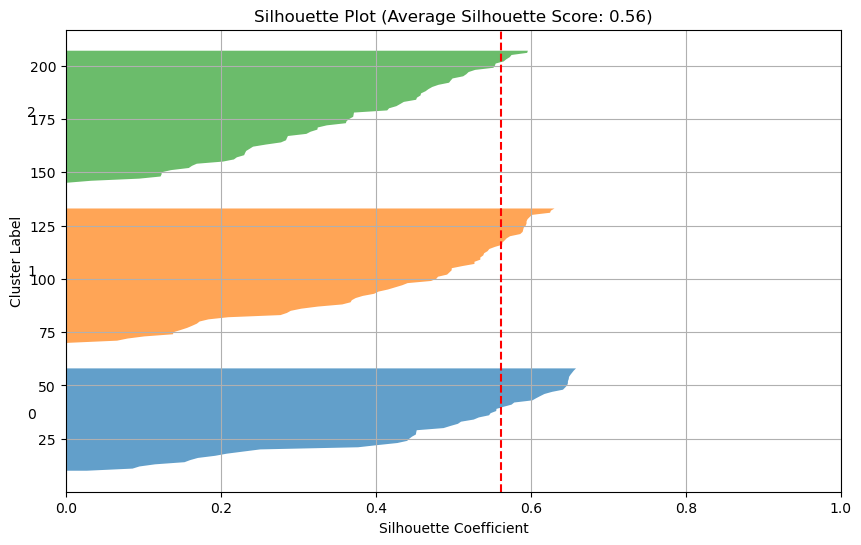

In [46]:
# KMeans

plt.figure(figsize=(10, 6))
y_lower = 10  # Initial position for the silhouette plots

for i in range(3):  # Change this if you have a different number of clusters
    # Aggregate the silhouette scores for samples belonging to cluster i
    cluster_silhouette_values = kmeans_samp_sil_val[best_labels_kmeans == i]
    cluster_silhouette_values.sort()

    # Determine the y position for the current cluster
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Fill the silhouette plot for the current cluster
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7)

    # Label the cluster
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))

    # Update the y_lower for the next cluster
    y_lower = y_upper + 10  # Add a space between clusters

# Aesthetics
plt.title(f'Silhouette Plot (Average Silhouette Score: {best_silhouette_kmeans:.2f})')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster Label')
plt.axvline(x=best_silhouette_kmeans, color='red', linestyle='--')  # Vertical line for average score
plt.xlim([0, 1])
plt.grid()
plt.show()

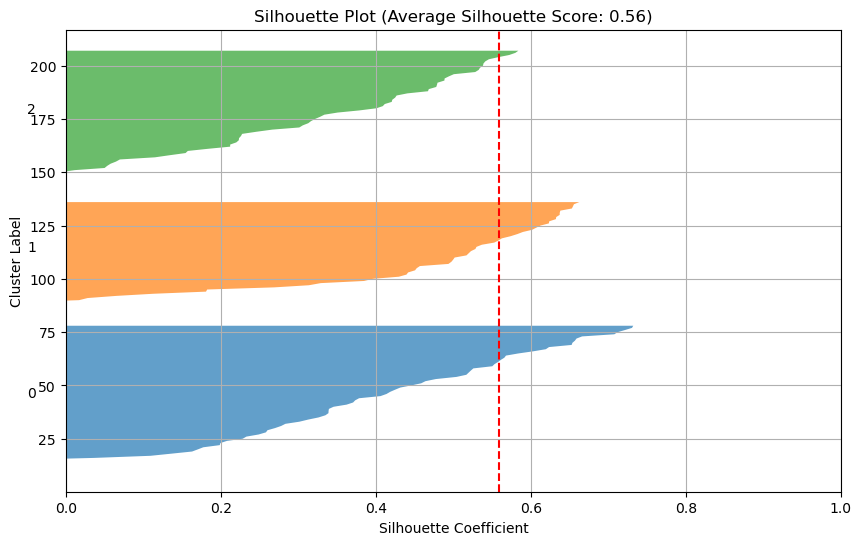

In [47]:
# agg cluster

plt.figure(figsize=(10, 6))
y_lower = 10  # Initial position for the silhouette plots

for i in range(3):  # Change this if you have a different number of clusters
    # Aggregate the silhouette scores for samples belonging to cluster i
    cluster_silhouette_values = agg_cluster_samp_sil_val[best_labels_agg == i]
    cluster_silhouette_values.sort()

    # Determine the y position for the current cluster
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Fill the silhouette plot for the current cluster
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7)

    # Label the cluster
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))

    # Update the y_lower for the next cluster
    y_lower = y_upper + 10  # Add a space between clusters

# Aesthetics
plt.title(f'Silhouette Plot (Average Silhouette Score: {best_silhouette_agg:.2f})')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster Label')
plt.axvline(x=best_silhouette_agg, color='red', linestyle='--')  # Vertical line for average score
plt.xlim([0, 1])
plt.grid()
plt.show()

 - Not sure what difference there was between doing gridsearch and the manual runs. They resulted in different outputs though.
>(professor, would you mind reviewing and telling me what went on to cause this difference? I am really curious but cannot pinpoint it. Spent hours on this and maybe it's a small mistake, but still, couldnt get any conclusive evidence)
 - Tried for a while to resolve this difference but couldn't come up with an answer, other than that gridsearch is using different code to work out the problem than me
 - From results of doing the run manually, I was able to get Kmeans and Agglomerative clustering to work. DBSCAN did not work for the manual run, but did work for Gridsearch
 - The scoring I got from doing it manually and doing a silhouette plot shows that the clusters are valid. There is stronger evidence that the agglomerative approach works better than Kmeans
 - Even though the silhouette score is 0.56, it is not enough evidence to conclude that any of the methods shown here are a great clustering method. These models are acceptable, but a stronger score would be ideal.